In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs('analysis_results/4_heatmaps_final', exist_ok=True)
print("Output directory: analysis_results/4_heatmaps_final")

Output directory: analysis_results/4_heatmaps_final


In [2]:
def get_mediators():
    return ['cardio28', 'cns28', 'coag28', 'hepatic28', 'icufd', 'orgfree28', 'pulmon28', 'renal28', 'vfd']

def get_cirrhosis_groups():
    return [
        ('Access/cirrhosis_absent_group3_nondrinker_vs_anydrinker_first_results.csv', 'Cirr Absent\nND vs Any'),
        ('Access/cirrhosis_present_group3_nondrinker_vs_anydrinker_first_results.csv', 'Cirr Present\nND vs Any'),
        ('Access/cirrhosis_absent_group4_nondrinker_vs_moderate_first_results.csv', 'Cirr Absent\nND vs MD'),
        ('Access/cirrhosis_present_group4_nondrinker_vs_moderate_first_results.csv', 'Cirr Present\nND vs MD'),
        ('Access/cirrhosis_absent_group1_nondrinker_vs_heavy_first_results.csv', 'Cirr Absent\nND vs HD'),
        ('Access/cirrhosis_present_group1_nondrinker_vs_heavy_first_results.csv', 'Cirr Present\nND vs HD')
    ]

def get_gender_groups():
    return [
        ('Access/gender_male_group1_nondrinker_vs_heavy_first_results.csv', 'Male\nND vs HD'),
        ('Access/gender_female_group1_nondrinker_vs_heavy_first_results.csv', 'Female\nND vs HD'),
        ('Access/gender_male_group3_nondrinker_vs_anydrinker_first_results.csv', 'Male\nND vs Any'),
        ('Access/gender_female_group3_nondrinker_vs_anydrinker_first_results.csv', 'Female\nND vs Any'),
        ('Access/gender_male_group4_nondrinker_vs_moderate_first_results.csv', 'Male\nND vs MD'),
        ('Access/gender_female_group4_nondrinker_vs_moderate_first_results.csv', 'Female\nND vs MD')
    ]

mediators = get_mediators()
cirrhosis_groups = get_cirrhosis_groups()
gender_groups = get_gender_groups()

print(f"Mediators: {len(mediators)}")
print(f"Cirrhosis groups: {len(cirrhosis_groups)} (6 columns expected)")
print(f"Gender groups: {len(gender_groups)} (6 columns expected)")

Mediators: 9
Cirrhosis groups: 6 (6 columns expected)
Gender groups: 6 (6 columns expected)


In [ ]:
def filter_mediator_to_mediator(df, mediators):
    return df[(df['treatment'].isin(mediators)) & (df['outcome'].isin(mediators))]

def filter_alcohol_and_mediator_to_death(df, mediators):
    alcohol_to_mediator = df[(df['treatment'] == 'alcohol_binary') & (df['outcome'].isin(mediators))]
    mediator_to_death = df[(df['treatment'].isin(mediators)) & (df['outcome'] == 'death90')]
    return pd.concat([alcohol_to_mediator, mediator_to_death], ignore_index=True)

def build_heatmap_raw_values(file_list, filter_func, mediators):
    all_pathways = set()
    pathway_effects = {}
    
    for file_path, group_name in file_list:
        df = pd.read_csv(file_path)
        df = filter_func(df, mediators)
        
        df['pathway'] = df['treatment'] + ' → ' + df['outcome']
        all_pathways.update(df['pathway'].unique())
        
        pathway_effects[group_name] = df.set_index('pathway')['effect'].to_dict()
    
    all_pathways_sorted = sorted(list(all_pathways))
    
    heatmap_data = []
    for pathway in all_pathways_sorted:
        row = []
        for file_path, group_name in file_list:
            effect = pathway_effects[group_name].get(pathway, np.nan)
            row.append(effect)
        heatmap_data.append(row)
    
    column_names = [name for _, name in file_list]
    heatmap_df = pd.DataFrame(heatmap_data, index=all_pathways_sorted, columns=column_names)
    
    return heatmap_df

def create_heatmap(heatmap_df, title, filename, output_dir, is_mediator_to_mediator=False):
    n_rows = len(heatmap_df)
    n_cols = len(heatmap_df.columns)
    
    fig_width = max(12, n_cols * 2.0)
    
    if is_mediator_to_mediator:
        fig_height = max(18, n_rows * 0.85)
        font_size = 14
    else:
        fig_height = max(16, n_rows * 0.7)
        if n_rows <= 20:
            font_size = 14
        elif n_rows <= 30:
            font_size = 12
        else:
            font_size = 10
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    actual_min = heatmap_df.min().min()
    actual_max = heatmap_df.max().max()
    
    vmin = actual_min
    vmax = actual_max
    
    annot_array = np.empty_like(heatmap_df, dtype=object)
    for i in range(heatmap_df.shape[0]):
        for j in range(heatmap_df.shape[1]):
            val = heatmap_df.iloc[i, j]
            if pd.notna(val):
                annot_array[i, j] = f'{val:.3f}'
            else:
                annot_array[i, j] = ''
    
    sns.heatmap(heatmap_df, cmap='Blues_r', vmin=vmin, vmax=vmax,
                annot=annot_array, fmt='', linewidths=0.8,
                cbar_kws={'label': 'Effect Value (DoWhy)', 'shrink': 0.75}, ax=ax,
                annot_kws={'fontsize': font_size, 'fontweight': 'bold'})
    
    ax.set_title(title, fontsize=20, fontweight='bold', pad=25)
    ax.set_xlabel('Comparison Groups', fontsize=16, fontweight='bold', labelpad=10)
    ax.set_ylabel('Causal Pathways', fontsize=16, fontweight='bold', labelpad=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=13)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{output_dir}/{filename}.pdf', bbox_inches='tight')
    print(f"Saved: {filename}.png/pdf")
    print(f"  Shape: {n_rows} pathways × {n_cols} groups, font: {font_size}pt")
    print(f"  Data range: {actual_min:.3f} to {actual_max:.3f}")
    print(f"  Display range: {vmin:.3f} to {vmax:.3f}")
    plt.show()

print("Functions defined")

Functions defined



HEATMAP 1: Mediator→Mediator (Cirrhosis Groups)
Saved: 1_mediator_to_mediator_cirrhosis.png/pdf
  Shape: 38 pathways × 6 groups, font: 14pt
  Data range: 0.010 to 0.993
  Display range: 0.010 to 0.993


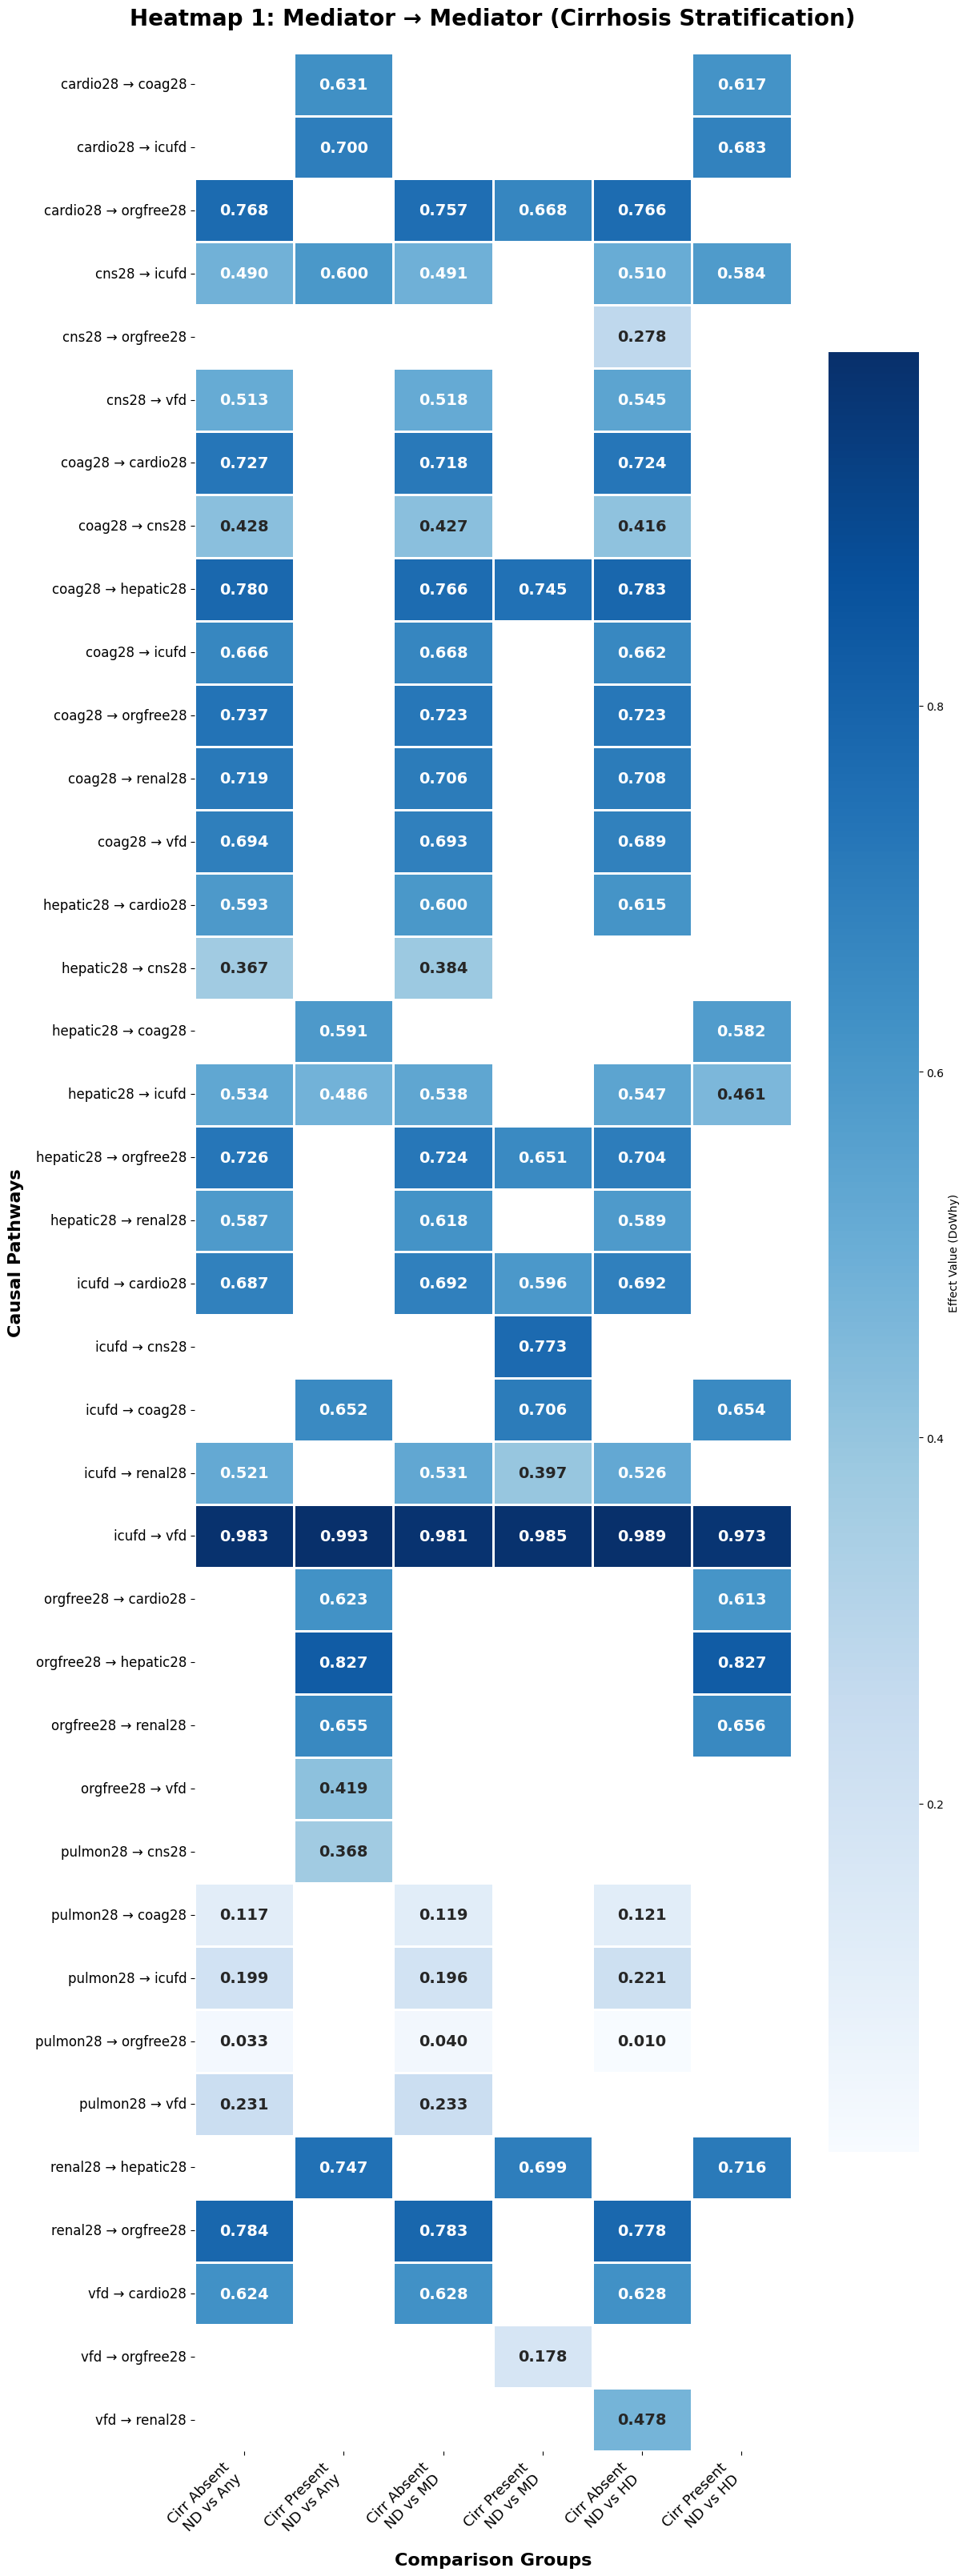

In [4]:
output_dir = 'analysis_results/4_heatmaps_final'

print("\n" + "="*60)
print("HEATMAP 1: Mediator→Mediator (Cirrhosis Groups)")
print("="*60)

heatmap1 = build_heatmap_raw_values(cirrhosis_groups, filter_mediator_to_mediator, mediators)
create_heatmap(heatmap1, 
               'Heatmap 1: Mediator → Mediator (Cirrhosis Stratification)',
               '1_mediator_to_mediator_cirrhosis',
               output_dir,
               is_mediator_to_mediator=True)


HEATMAP 2: Mediator→Mediator (Gender Groups)
Saved: 2_mediator_to_mediator_gender.png/pdf
  Shape: 31 pathways × 6 groups, font: 14pt
  Data range: -0.027 to 0.990
  Display range: -0.027 to 0.990


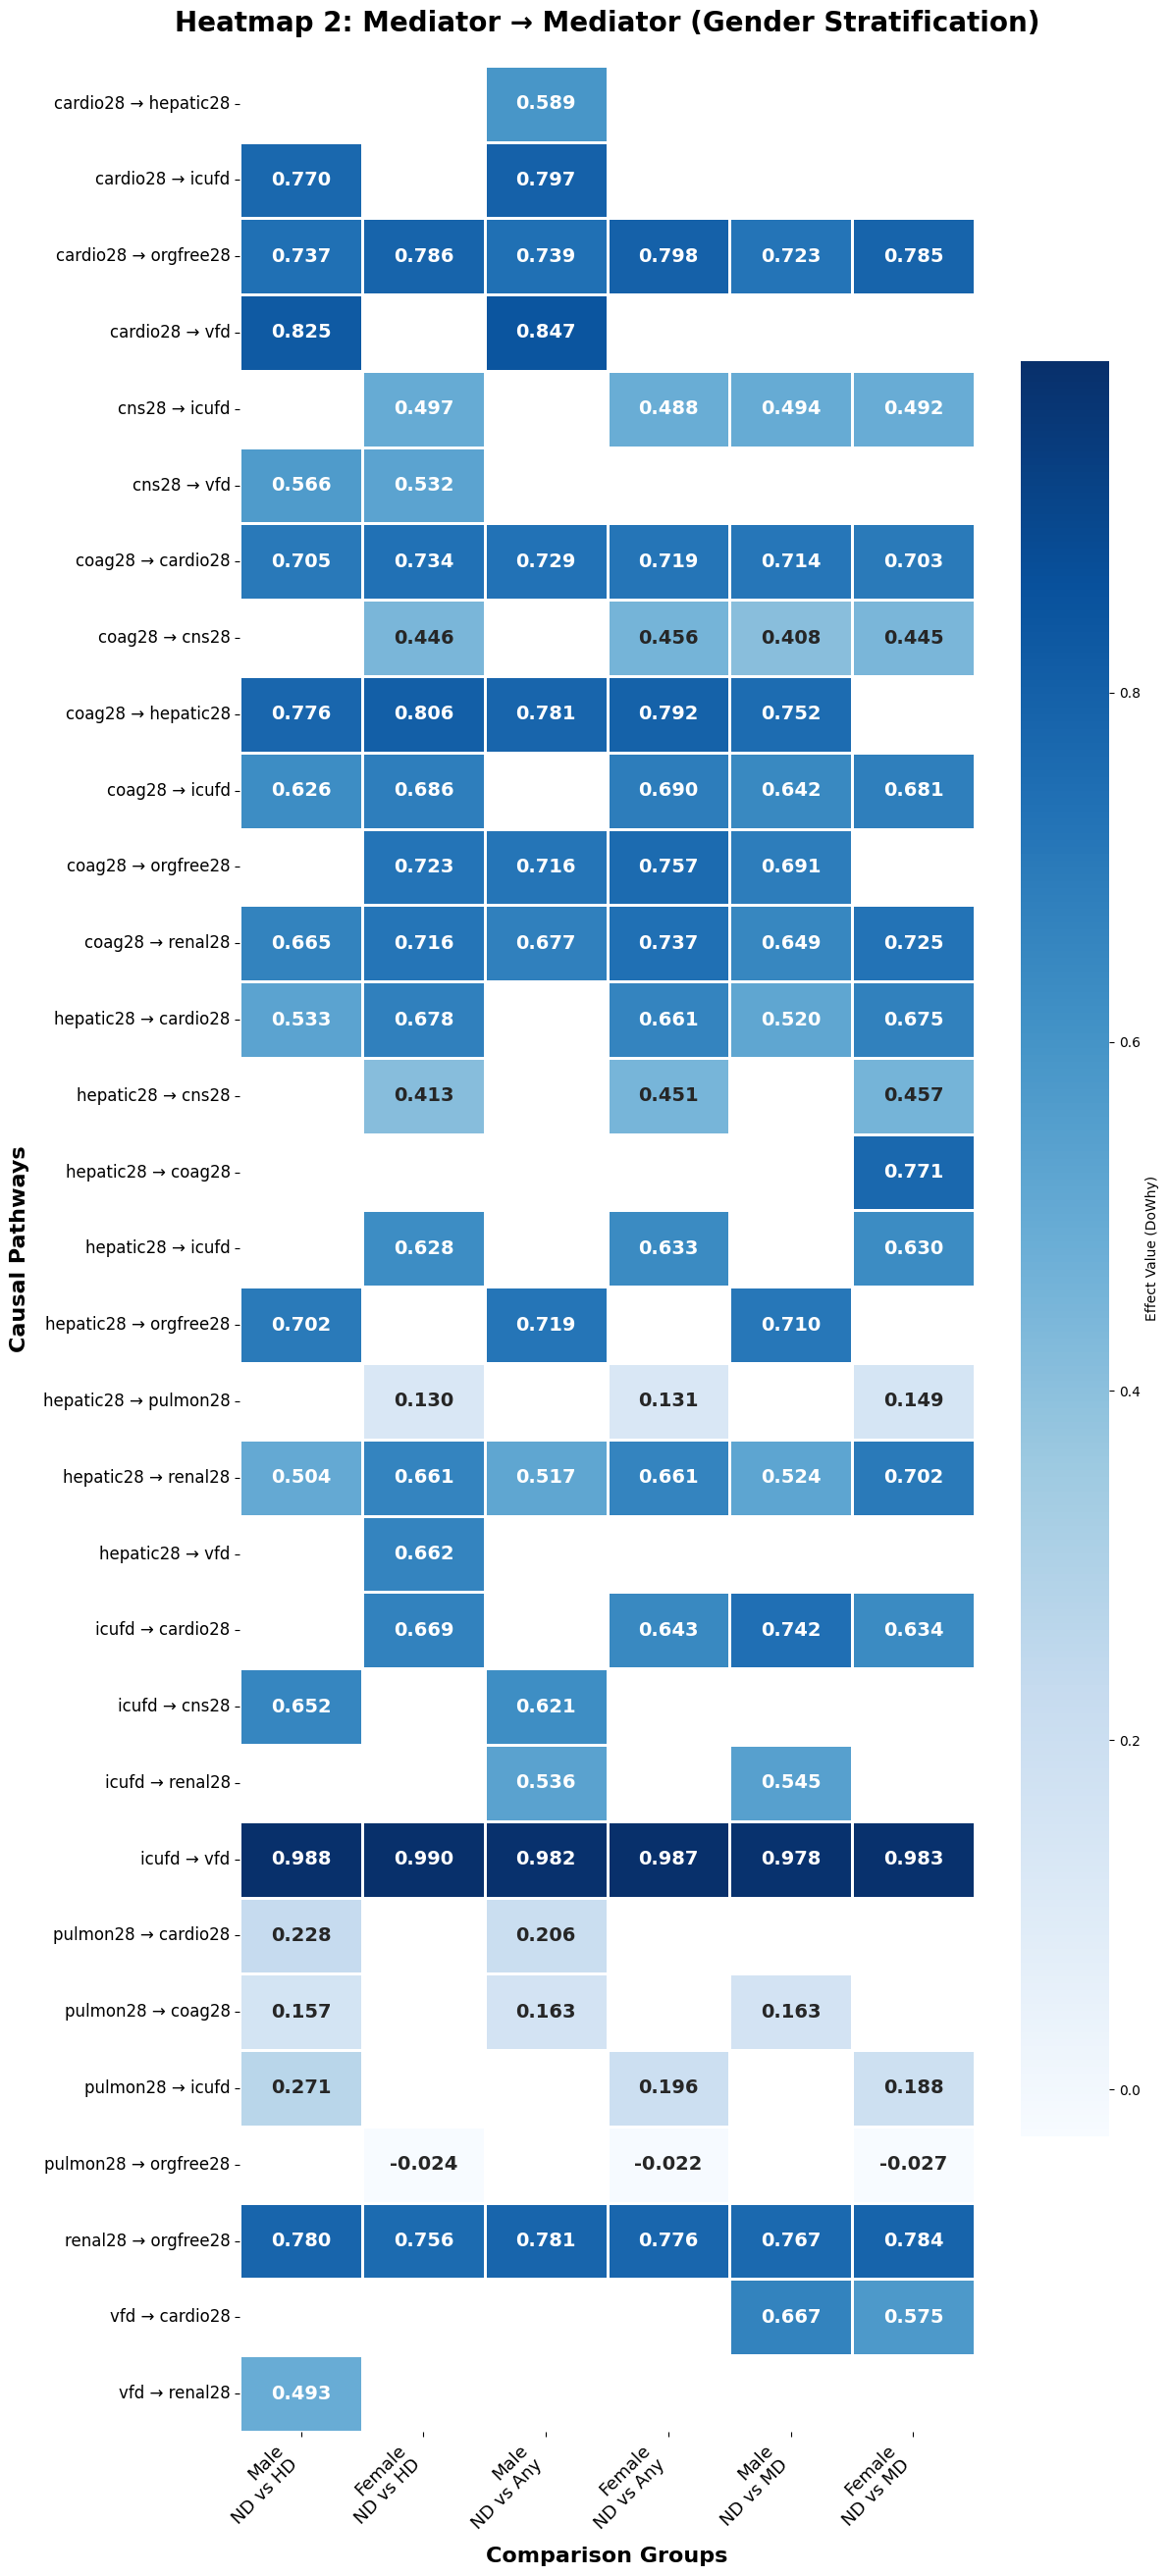

In [5]:
print("\n" + "="*60)
print("HEATMAP 2: Mediator→Mediator (Gender Groups)")
print("="*60)

heatmap2 = build_heatmap_raw_values(gender_groups, filter_mediator_to_mediator, mediators)
create_heatmap(heatmap2,
               'Heatmap 2: Mediator → Mediator (Gender Stratification)',
               '2_mediator_to_mediator_gender',
               output_dir,
               is_mediator_to_mediator=True)


HEATMAP 3: Alcohol→Mediator + Mediator→Death90 (Cirrhosis Groups)
Saved: 3_alcohol_mediator_death_cirrhosis.png/pdf
  Shape: 18 pathways × 6 groups, font: 14pt
  Data range: -7.984 to -0.000
  Display range: -7.984 to -0.000


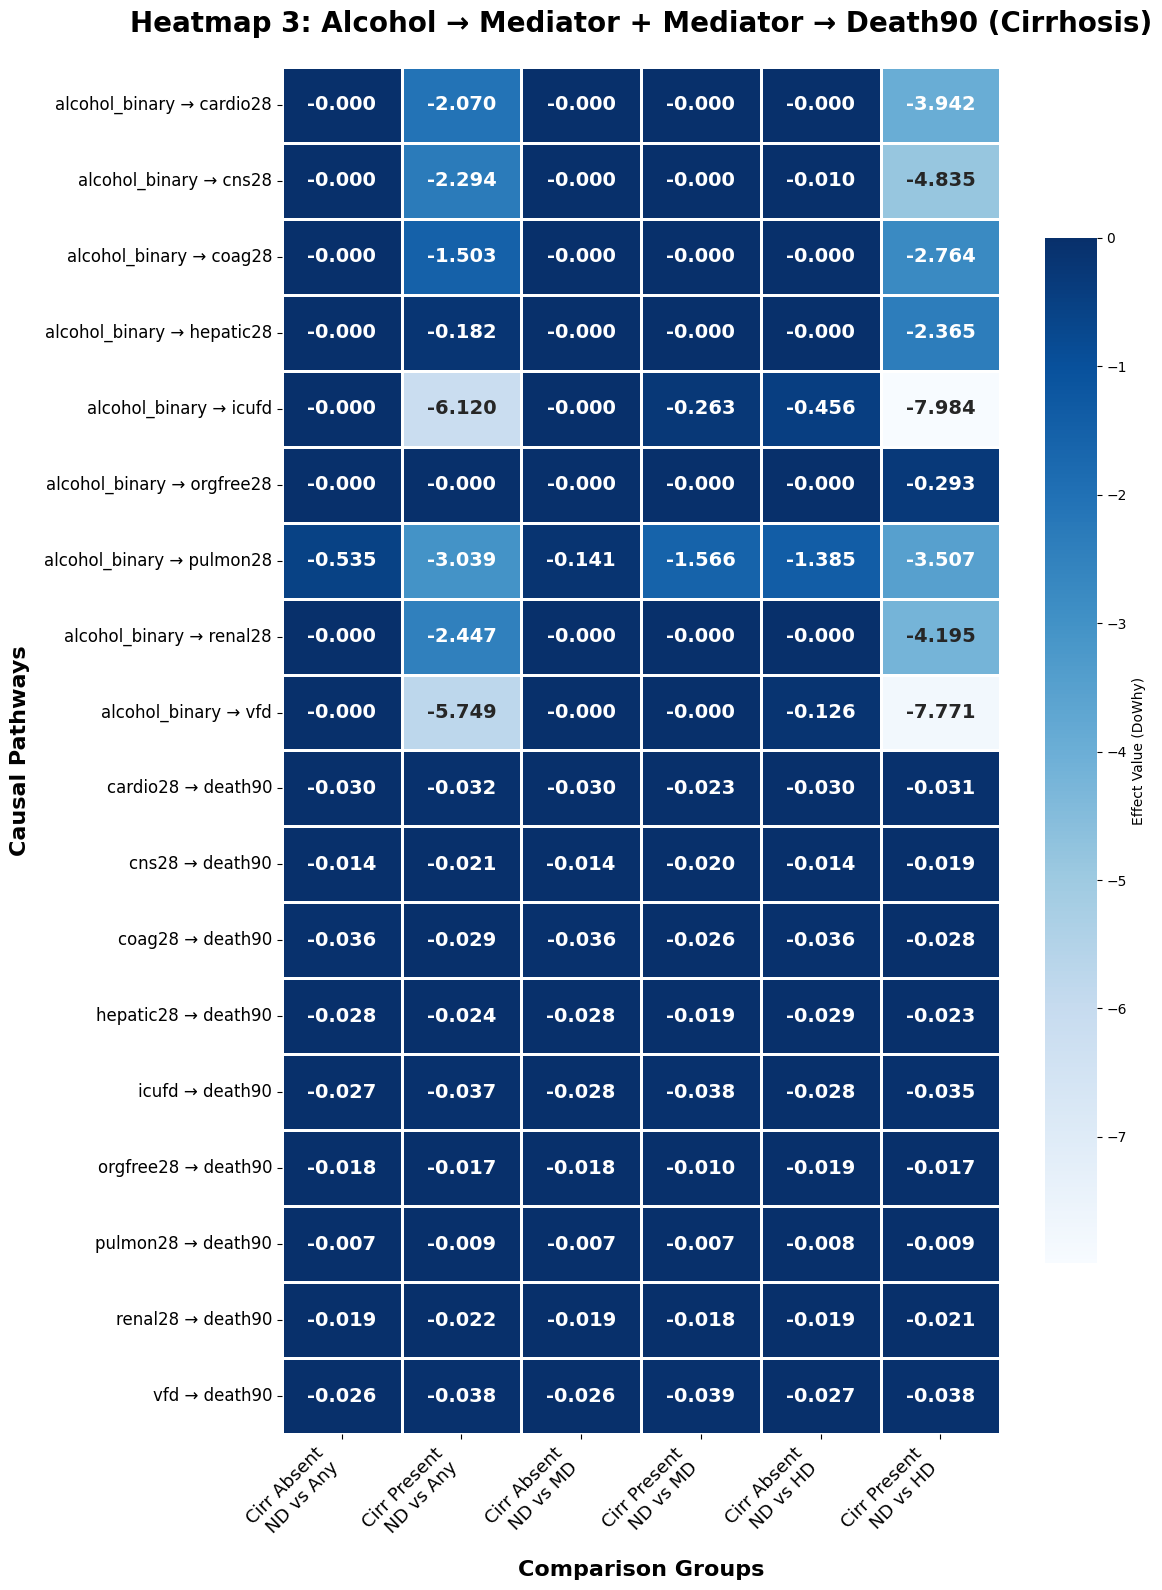

In [6]:
print("\n" + "="*60)
print("HEATMAP 3: Alcohol→Mediator + Mediator→Death90 (Cirrhosis Groups)")
print("="*60)

heatmap3 = build_heatmap_raw_values(cirrhosis_groups, filter_alcohol_and_mediator_to_death, mediators)
create_heatmap(heatmap3,
               'Heatmap 3: Alcohol → Mediator + Mediator → Death90 (Cirrhosis)',
               '3_alcohol_mediator_death_cirrhosis',
               output_dir)


HEATMAP 4: Alcohol→Mediator + Mediator→Death90 (Gender Groups)
Saved: 4_alcohol_mediator_death_gender.png/pdf
  Shape: 18 pathways × 6 groups, font: 14pt
  Data range: -2.192 to -0.000
  Display range: -2.192 to -0.000


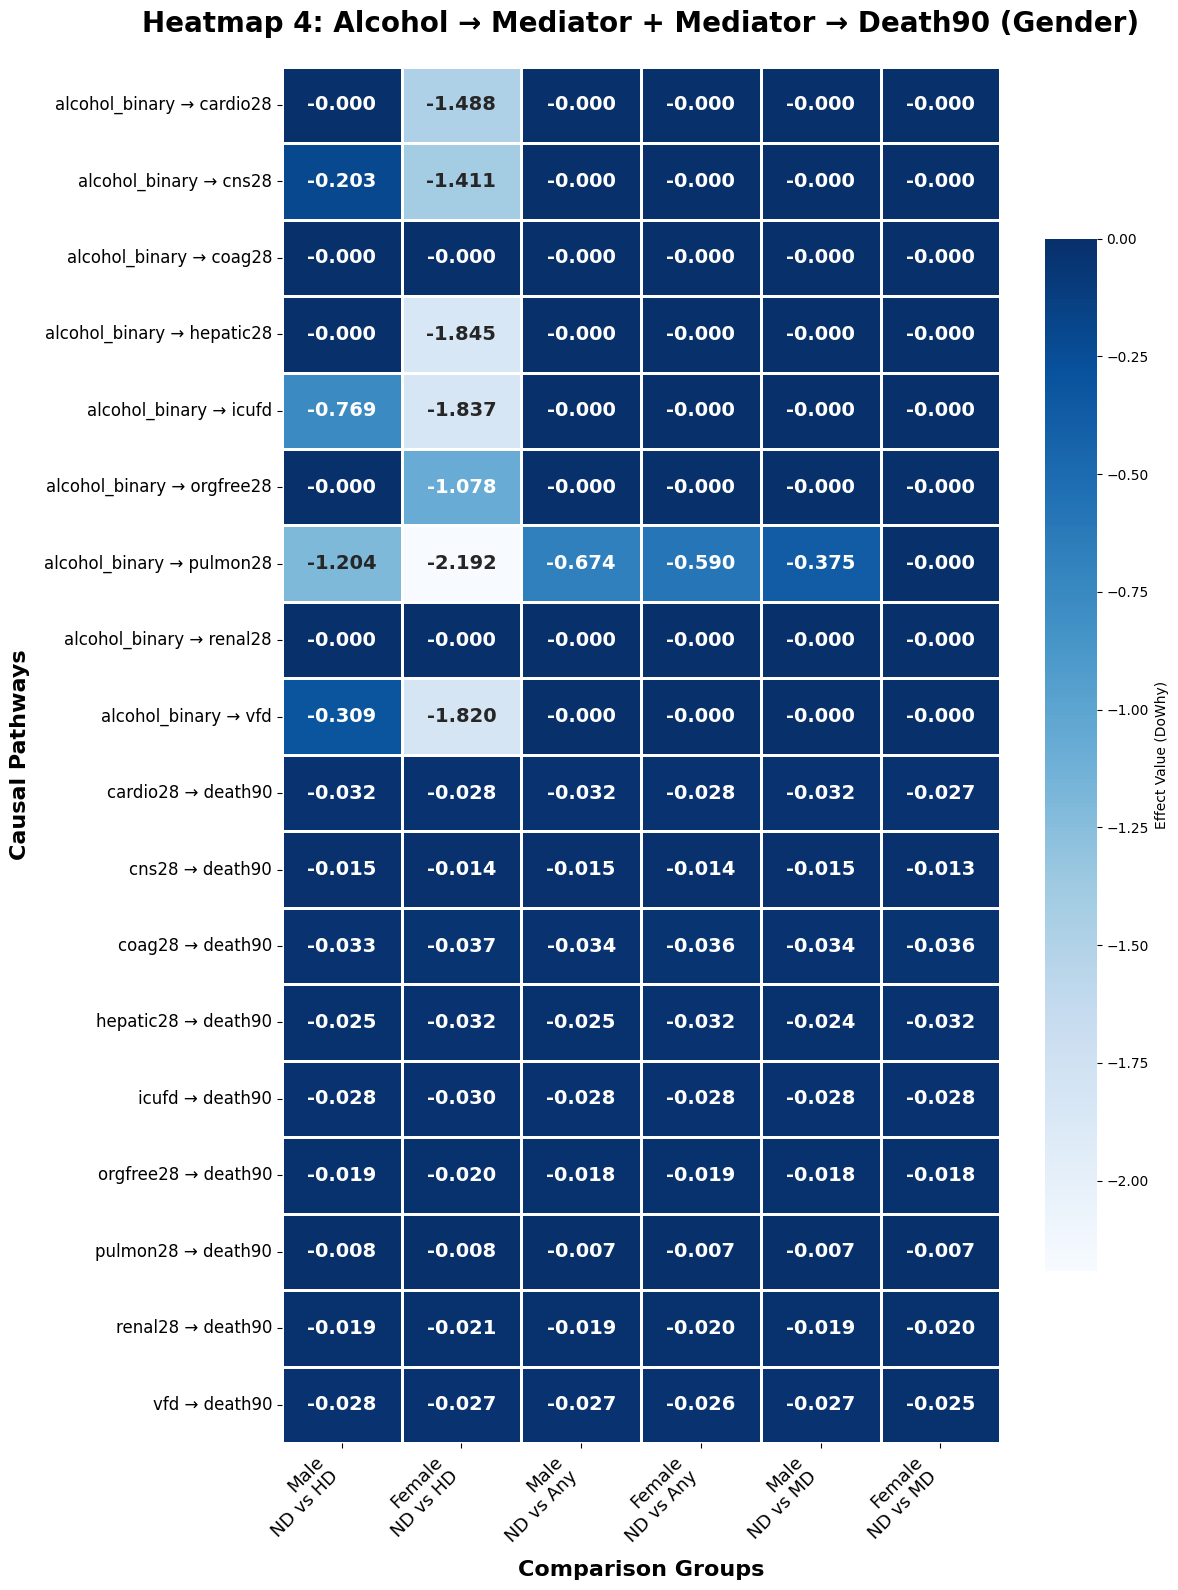

In [7]:
print("\n" + "="*60)
print("HEATMAP 4: Alcohol→Mediator + Mediator→Death90 (Gender Groups)")
print("="*60)

heatmap4 = build_heatmap_raw_values(gender_groups, filter_alcohol_and_mediator_to_death, mediators)
create_heatmap(heatmap4,
               'Heatmap 4: Alcohol → Mediator + Mediator → Death90 (Gender)',
               '4_alcohol_mediator_death_gender',
               output_dir)

In [8]:
print("\n" + "="*60)
print("4 HEATMAPS COMPLETE")
print("="*60)
print("\nGenerated 4 heatmaps (each with 6 columns):")
print("  1. Mediator→Mediator (Cirrhosis: 6 groups)")
print("  2. Mediator→Mediator (Gender: 6 groups)")
print("  3. Alcohol→Mediator + Mediator→Death90 (Cirrhosis: 6 groups)")
print("  4. Alcohol→Mediator + Mediator→Death90 (Gender: 6 groups)")
print("\nFeatures:")
print("  - Raw DoWhy effect values (not differences)")
print("  - Only binary alcohol (no drinks_per_week)")
print("  - All values visible with adaptive font sizing")
print("  - Consistent RdBu_r colormap with symmetric scaling")
print("="*60)


4 HEATMAPS COMPLETE

Generated 4 heatmaps (each with 6 columns):
  1. Mediator→Mediator (Cirrhosis: 6 groups)
  2. Mediator→Mediator (Gender: 6 groups)
  3. Alcohol→Mediator + Mediator→Death90 (Cirrhosis: 6 groups)
  4. Alcohol→Mediator + Mediator→Death90 (Gender: 6 groups)

Features:
  - Raw DoWhy effect values (not differences)
  - Only binary alcohol (no drinks_per_week)
  - All values visible with adaptive font sizing
  - Consistent RdBu_r colormap with symmetric scaling
